In [1]:
import sys
sys.path.append ('../../')
from pathlib import Path
import json
import pdb
import collections
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import tqdm
import math
import random as rand
import pytesseract
from PIL import Image
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/4.1.1/bin/tesseract'
path = Path()

tot_annot = json.load((path/"items_new_bounding_spider_37.json").open())
jpgs = Path()/'imagesv3'

cats = {1: "buttons", 2: "input", 3: "select", 4: "big heading", 
        5: "paragraphs", 6:"checkbox", 7: "above input", 8: "a", 9: "image", 10: "form",
       11: "legend", 12: "field", 13: "lists", 14: "list element", 15: "div", 16: "small heading", 
        17: "button type", 18: "text type"}
cats_reverse = {v: k for k,v in cats.items()}
used_cats = [str(k) for k in cats.keys()]
trn_fns = {page["page_id"]: page["filename"] for page in tot_annot}
"""
cats = {1: "button_type", 2: "input_type", 3: "text_type", 4: "text_type", 5: "text_type", 6: "input_type",
        7: "text_type", 8: "link_type", 9: "image_type", 10: "group_type", 11: "text_type", 12: "input_type",
        13: "group_type", 14: "text_type", 15: "group_type", 16: "text_type"}
used_cats = {"1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"}
"""
classes = []

In [124]:
urls[0]

NameError: name 'urls' is not defined

In [79]:
def get_bb(coords): 
    return np.array([coords['top'], coords['left'], coords['bottom'], coords['right']])

def open_image(fn):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    im = cv2.imread(str(fn), flags).astype(np.float32)/255
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def hw_bb(bb):
    # Example, bb = [155, 96, 196, 174]
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=6, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

def draw_im(im, ann, cls=None):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        # b is bbox, c is class id
        b = bb_hw(b)
        if cls is None or c == cls:
            draw_rect(ax, b)
            draw_text(ax, b[:2], cats[c], sz=6)

def draw_idx(i, ents=None, cls=None):
    # i is image id
    if ents is None: ents = trn_anno[i] # training annotations
    im = open_image(jpgs / trn_fns[i]) # trn_fns is training image file names
    draw_im(im, ents, cls) # im_a is an element of annotation

def process_ents(ents):
    new_ents = []
    for class_idx, coord_list in ents.items():
        if len(coord_list) <= 0: continue
        if len(coord_list['coords']) > 0:
            for coord in coord_list['coords']:
                bb = get_bb(coord)
                if bb[0] > 1024 or bb[1] > 768 or get_box_size(bb) <= 0: 
                    continue
                tampered = False
                if bb[0] < 0: 
                    tampered = True
                    bb[0] = 0
                if bb[1] < 0:
                    tampered = True
                    bb[1] = 0
                if bb[2] < 0: 
                    tampered = True
                    bb[2] = 0
                if bb[3] < 0: 
                    tampered = True
                    bb[3] = 0
                if bb[2] > 1024: 
                    tampered = True
                    bb[2] = 1024
                if bb[3] > 768: 
                    tampered = True
                    bb[3] = 768
                new_ents.append((bb,int(class_idx),tampered))
    return new_ents

def get_box_size(box):
    return (box[2]-box[0])*(box[3]-box[1])

def get_random_annotation_idx():
    return trn_annot_indexes[rand.randint(0,len(trn_annot_indexes))]
    
def draw_certain_class(cls):
    found = False
    while found is False:
        idx = get_random_annotation_idx()
        for el in trn_anno[idx]:
            if el[1] == cls:
                found = True
                break
    print(idx)
    draw_idx(idx, cls=cls)

def get_element_bounds(idx, cls=None):
    bounds = trn_anno[idx]
    
    if cls is None: return bounds
    
    ret = []
    
    for bo in bounds:
        if bo[1] == cls:
            ret.append(bo)
    
    return ret

def show_detected_text(img):
    det = pytesseract.image_to_data(Image.open(img), output_type=Output.DICT)
    
    img = open_image(img)
    ax = show_img(img, figsize=(16, 8))
    
    n_boxes = len(det['level'])
    
    for i in range(n_boxes):
        (x, y, w, h) = (det['left'][i], det['top'][i], det['width'][i], det['height'][i])
        draw_rect(ax, np.array([x,y,w,h]))
        draw_text(ax, np.array([x,y-15]), det['text'][i], sz=9)
        
trn_anno = collections.defaultdict(lambda:[])
seen_page_ids = set()
for i,img_annotations in (enumerate(tot_annot)):
    if img_annotations['page_id'] in seen_page_ids: continue
    seen_page_ids.add(img_annotations['page_id'])
    for class_idx,coord_list in img_annotations['entities'].items():
        if len(coord_list) <= 0: continue
        if len(coord_list['coords']) > 0:
            for coord in coord_list['coords']:
                bb = get_bb(coord)
                if bb[0] > 1024 or bb[1] > 768 or get_box_size(bb) <= 0: 
                    continue
                tampered = False
                if bb[0] < 0: 
                    tampered = True
                    bb[0] = 0
                if bb[1] < 0:
                    tampered = True
                    bb[1] = 0
                if bb[2] < 0: 
                    tampered = True
                    bb[2] = 0
                if bb[3] < 0: 
                    tampered = True
                    bb[3] = 0
                if bb[2] > 1024: 
                    tampered = True
                    bb[2] = 1024
                if bb[3] > 768: 
                    tampered = True
                    bb[3] = 768
                if tampered == True: continue
                trn_anno[img_annotations['page_id']].append((bb,int(class_idx)))
trn_annot_indexes = [i for i in trn_anno.keys()]

def detect_text(img):
    img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    return pytesseract.image_to_string(im_pil)

def get_text_info(img):
    img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    return pytesseract.image_to_data(im_pil, output_type=Output.DICT)

    
def get_crop(idx, bb, see_results=True):
    img = open_image(jpgs / trn_fns[idx])
    
    bb = bb[0]

    im = img[int(bb[0]):int(bb[2]), int(bb[1]):int(bb[3])]
    
    if see_results:
        ax = show_img(im)
    
        draw_rect(ax, bb_hw([0,0,bb[2]-bb[0], bb[3]-bb[1]]))
    
    return im

def get_text_on_bb(idx, bb, see_results=True):
    return get_text_info(get_crop(idx, bb, see_results))

def get_num_words(idx, bounds, see_results=True):
    info = get_text_on_bb(idx, bounds, see_results)
    if see_results:
        for word in info['text']:
            if word != "": print(word)        
    return max(info['word_num'])
            
    
def draw_idx(idx, ents=None, cls=None, with_filter=False):
    if ents is None: 
        ents = trn_anno[idx] # training annotations
    
    if with_filter: ents = filter_ents(idx, ents)
    
    im = open_image(jpgs / trn_fns[idx]) # trn_fns is training image file names
    draw_im(im, ents, cls) # im_a is an element of annotation

def draw_img(idx):
    show_img(open_image(jpgs / trn_fns[idx]), figsize=(8,16))

def get_rand_crop_words(idx, bounds):
    return get_num_words(idx, bounds[rand.randint(0, len(bounds)-1)])

In [122]:
def filter_li_bound(idx, li_bound):
    num_words = get_num_words(idx, li_bound, see_results=False)
    
    if num_words <= 0:
        return []
    elif num_words < 3:
        return [li_bound[0], cats_reverse["button type"]]
    else:
        return [li_bound[0], cats_reverse["text type"]]

def filter_a_bound(idx, a_bound):
    num_words = get_num_words(idx, a_bound, see_results=False)
    
    if num_words < 3:
        return [a_bound[0], cats_reverse["button type"]]
    else:
        return [a_bound[0], cats_reverse["text type"]]
    

def filter_ents(idx, ents):
    filtered_ents = []
    
    for ent in ents:
        colors = get_colors_of_bb(idx, ent, False)
        if len(colors) < 2: continue
        color_sum = 0
        for col in colors:
            color_sum += col[0]
        if colors[0][0] / color_sum >= 0.95: continue
        
        if ent[1] == cats_reverse['list element']:
            filt = filter_li_bound(idx, ent)
            if len(filt) > 0:
                filtered_ents.append(filter_li_bound(idx, ent))
        elif ent[1] == cats_reverse["a"]:
            filtered_ents.append(filter_a_bound(idx,ent))
        else:
            filtered_ents.append(ent)
            
    return filtered_ents

# Blank Element Filtering

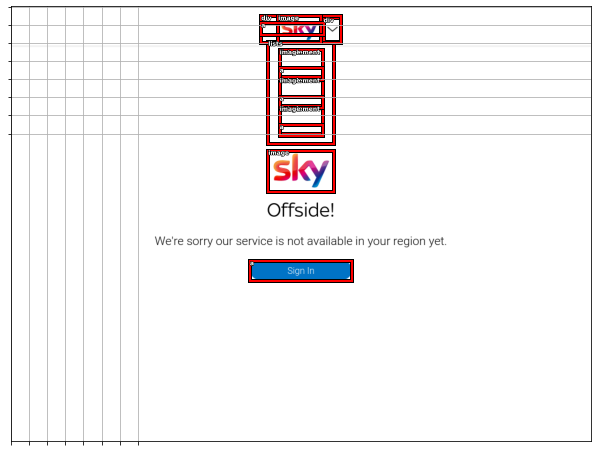

In [6]:
draw_idx(26418)

In [121]:
def opencv_to_pil(im):
    img = np.uint8(im*255)
    im_pil = Image.fromarray(img)
    return im_pil

def open_pil(path):
    return opencv_to_pil(open_image(path))

def get_colors_of_bb(idx, bb, see_results=True):
    crop_image = get_crop(idx, bb, see_results)
    pim = opencv_to_pil(crop_image)
    colors = pim.getcolors(pim.size[0]*pim.size[1])
    colors.sort(key=lambda x: x[0], reverse=True)

    return colors

def get_rand_bb_colors(idx, cls=None):
    bounds = get_element_bounds(idx, cls)
    return get_colors_of_bb(idx, bounds[rand.randint(0, len(bounds)-1)])

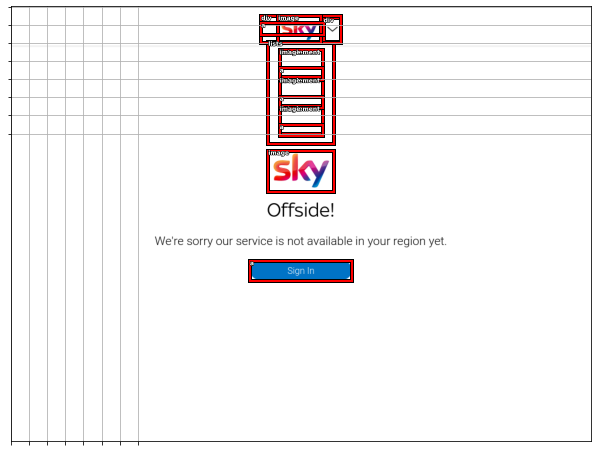

In [63]:
draw_idx(26418)

4

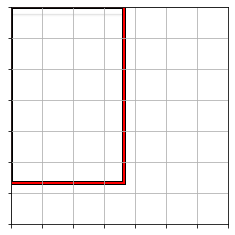

In [86]:
colors = get_rand_bb_colors(26418)
len(colors)

In [87]:
colors

[(20355, (255, 255, 255)),
 (115, (252, 252, 252)),
 (115, (244, 244, 244)),
 (115, (227, 227, 227))]

4
52
1164
1
1
1
2359
1
1
1
1113
124
1
1
1
801


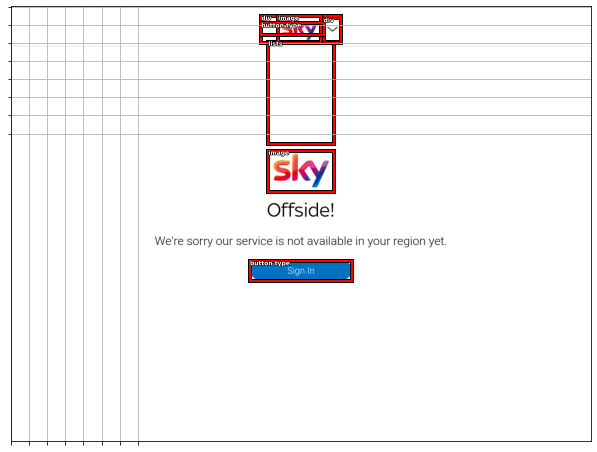

In [82]:
draw_idx(26418, with_filter=True)

(37, 170, 3)


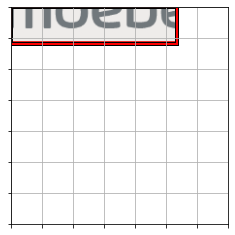

In [116]:
colors = get_rand_bb_colors(25496)

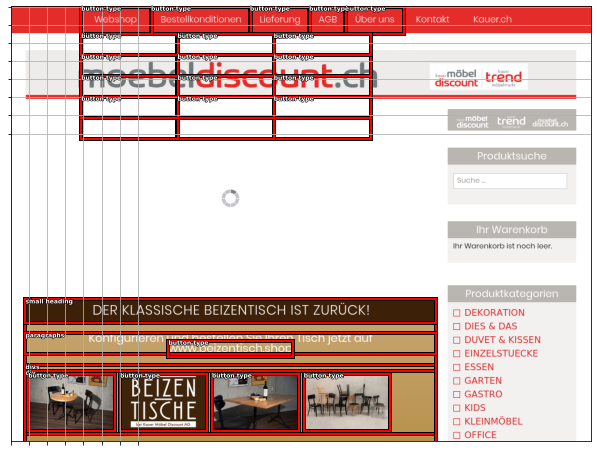

In [123]:
draw_idx(25496, with_filter=True)